#  Simple K-Nearest Neighbors using partial sort

Sometimes we are re not interested in sorting an entire array but simply want to find its K smallest values. NumPy provides the `np.partition` function for that. `np.partition` takes an array and a number K an returns a new array with the smallest K+1 values to the left of the partition, and the remaining values to the right, in **arbitrary** order:

In [1]:
import numpy as np

x = np.array([7, 2, 4, 1, 5, 6, 3])
np.partition(x, 3)

array([1, 2, 4, 7, 5, 6, 3])

Note that the first 4 entries are the smallest (1,2,3 and 4) but they are in arbitrary order. Analogously we can partially order matrices rows or columns.

In [2]:
rand = np.random.RandomState(0)
X = rand.randint(0, 10, (4, 6))
X

array([[5, 0, 3, 3, 7, 9],
       [3, 5, 2, 4, 7, 6],
       [8, 8, 1, 6, 7, 7],
       [8, 1, 5, 9, 8, 9]])

In [3]:
np.partition(X, 1, axis=1)

array([[0, 3, 5, 3, 7, 9],
       [2, 3, 5, 4, 7, 6],
       [1, 6, 8, 8, 7, 7],
       [1, 5, 8, 9, 8, 9]])

Note that the rows are ordered such that the first two entries (of each row) represent the smallest values.

Just as there is a `np.argsort` that computes indices of the sort, there is a `np.argpartition` that computes indices of the partition. 

## Example: K-Nearest Neighbors

Let's see how we might use these `argsort` and `argpartition` functions to find the nearest neighbors of each point in a set. We'll create a random set of 10 points on a plane.
We'll arrange these points in a $10\times 2$ array:

In [4]:
X = rand.rand(10, 2)
X

array([[0.64817187, 0.36824154],
       [0.95715516, 0.14035078],
       [0.87008726, 0.47360805],
       [0.80091075, 0.52047748],
       [0.67887953, 0.72063265],
       [0.58201979, 0.53737323],
       [0.75861562, 0.10590761],
       [0.47360042, 0.18633234],
       [0.73691818, 0.21655035],
       [0.13521817, 0.32414101]])

In [5]:
np.sum(X,1)

array([1.01641341, 1.09750594, 1.3436953 , 1.32138823, 1.39951218,
       1.11939302, 0.86452323, 0.65993276, 0.95346853, 0.45935918])

Let's plot the points.

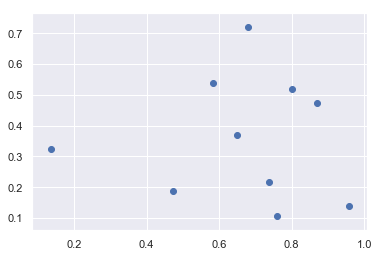

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling

plt.scatter(X[:, 0], X[:, 1]);

We'll compute the distance between each pair of points. To do that, recall that the squared-distance between two points is the sum of the squared differences in each dimension. Using NumPy [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) and aggregation routines we can compute the matrix of square distances in a single line of code:

In [7]:
dist_sq = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)

Here `None` is exactly the same as `np.newaxis`. Let's visualize each single operand.

In [8]:
print(X.shape)
X

(10, 2)


array([[0.64817187, 0.36824154],
       [0.95715516, 0.14035078],
       [0.87008726, 0.47360805],
       [0.80091075, 0.52047748],
       [0.67887953, 0.72063265],
       [0.58201979, 0.53737323],
       [0.75861562, 0.10590761],
       [0.47360042, 0.18633234],
       [0.73691818, 0.21655035],
       [0.13521817, 0.32414101]])

In [9]:
X[:, None, :]

array([[[0.64817187, 0.36824154]],

       [[0.95715516, 0.14035078]],

       [[0.87008726, 0.47360805]],

       [[0.80091075, 0.52047748]],

       [[0.67887953, 0.72063265]],

       [[0.58201979, 0.53737323]],

       [[0.75861562, 0.10590761]],

       [[0.47360042, 0.18633234]],

       [[0.73691818, 0.21655035]],

       [[0.13521817, 0.32414101]]])

In [10]:
X[:, None, :].shape

(10, 1, 2)

Think of `X[:, None, :]` as a column vector containing the 10 pairs.

In [11]:
X[None, :, :]

array([[[0.64817187, 0.36824154],
        [0.95715516, 0.14035078],
        [0.87008726, 0.47360805],
        [0.80091075, 0.52047748],
        [0.67887953, 0.72063265],
        [0.58201979, 0.53737323],
        [0.75861562, 0.10590761],
        [0.47360042, 0.18633234],
        [0.73691818, 0.21655035],
        [0.13521817, 0.32414101]]])

In [12]:
X[None, :, :].shape

(1, 10, 2)

Think of `X[None, :, :]` as a 1x1 row vector containing the $10 \times 2$ point matrix X. When evaluating the difference

 `X[:, None, :] - X[None, :, :]` 

it happens that, for each pair $p$ in the first operand (the 10 pairs column vector), $p-q$ is performed with respect to each row $q$ of the matrix X. This way one obtains a matrix for each $p$, i.e. a collection of 10 matrices. Then we take the square entry-wise and finally sum along the axis #2 (equivalently denoted with -1), that is along the rows of the inner matrices. For real, it's easier to see than to describe! 

Let's show the squared distances:

In [13]:
dist_sq

array([[0.        , 0.14740487, 0.06034854, 0.04650495, 0.12512246,
        0.03298163, 0.08101691, 0.06356615, 0.03088612, 0.26506635],
       [0.14740487, 0.        , 0.11864122, 0.16890862, 0.41416438,
        0.29835337, 0.04060428, 0.23593949, 0.0543107 , 0.70935926],
       [0.06034854, 0.11864122, 0.        , 0.00698213, 0.09758155,
        0.08704886, 0.14762954, 0.23972914, 0.08381266, 0.56237297],
       [0.04650495, 0.16890862, 0.00698213, 0.        , 0.05495371,
        0.04819872, 0.17365706, 0.21878503, 0.09646675, 0.48169462],
       [0.12512246, 0.41416438, 0.09758155, 0.05495371, 0.        ,
        0.04296583, 0.38424473, 0.32761634, 0.25746745, 0.4527733 ],
       [0.03298163, 0.29835337, 0.08704886, 0.04819872, 0.04296583,
        0.        , 0.21734867, 0.13498446, 0.12692083, 0.24509967],
       [0.08101691, 0.04060428, 0.14762954, 0.17365706, 0.38424473,
        0.21734867, 0.        , 0.08770181, 0.0127126 , 0.4362502 ],
       [0.06356615, 0.23593949, 0.2397291

All this might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. Just to double-check what we are doing, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zero:

In [14]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Now that we have the pairwise square-distances, we can use ``np.argsort`` to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [15]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 8 5 3 2 7 6 4 1 9]
 [1 6 8 2 0 3 7 5 4 9]
 [2 3 0 8 5 4 1 6 7 9]
 [3 2 0 5 4 8 1 6 7 9]
 [4 5 3 2 0 8 7 6 1 9]
 [5 0 4 3 2 8 7 6 9 1]
 [6 8 1 0 7 2 3 5 4 9]
 [7 0 8 6 9 5 3 1 2 4]
 [8 6 0 1 7 2 3 5 4 9]
 [9 7 5 0 8 6 4 3 2 1]]


The first column gives the numbers 0 through 9 in order: it's normal and it is due to the fact that the closest neighbor of a point is the point itself, as we would expect.

We used a full sort here... but we have actually done more work than needed. To determine the nearest $K$ neighbors, all we need is to partition each row so that the smallest $K + 1$ squared distances come first. The larger distances will fill the remaining positions of the array. This can be accomplished using the `np.argpartition` function:

In [16]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)

Let's plot the points along with lines representing the connections from each point to its two nearest neighbors:

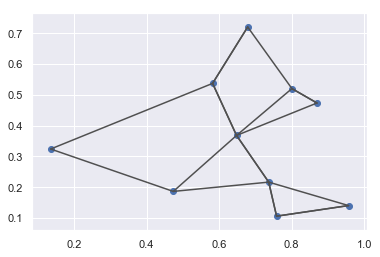

In [17]:
plt.scatter(X[:, 0], X[:, 1])

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color="#505050") # the asterisk "*" is used to unpack data from zip construct

Each point in the plot has lines drawn to its two nearest neighbors.
At first glance, it might seem strange that some of the points have more than two lines coming out of them: this is due to the fact that if point A is one of the two nearest neighbors of point B, this does not necessarily imply that point B is one of the two nearest neighbors of point A.

This code is written in a way that is invariant with respect to the size of the input data: we could just as easily compute the neighbors among 100 or 1,000,000 points in any number of dimensions, and the code would look the same.